# Welcome to the short tutorial on the analysis and visualization of microbiological data using QIIME 2 and Python!

# Step 1
### Load required packages:

### Select the ***Cell*** below (it will highligh in **blue or green** nad press ***Run*** (if unsure please refer to the Manual)

### Yuo can also run the ***Cell*** using keyboard: first highlight the ***Cell***, hold **Ctrl** and press **Enter** (Ctrl + Enter)

### If everything is working 'Packages loaded' will appear in the output:

<a href="https://i.imgur.com/Ip1AU12.gif[/img]"><img src="https://i.imgur.com/Ip1AU12.gif" alt="drawing" width="300"/></a>
Click to enlarge

In [1]:
import pandas as pd
import numpy as np
from skbio.diversity import alpha_diversity
from skbio.diversity import get_alpha_diversity_metrics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

your_number='05'

print('>>> Packages loaded <<<')

>>> Packages loaded <<<


### Lets start by taking a look at sequencing output.
Again, highlight the cell below and run it!

In [2]:
!ls ../../fastq/

10k-V3-02-22-R24_11_L001_R1_001.fastq.gz
10k-V3-02-22-R24_28_L001_R2_001.fastq.gz
10k-V3-05-22-R23_10_L001_R1_001.fastq.gz
10k-V3-05-22-R23_27_L001_R2_001.fastq.gz
10k-V3-07-21-R23_0_L001_R1_001.fastq.gz
10k-V3-07-21-R23_17_L001_R2_001.fastq.gz


# Step 2
### Import the sequence data to QIIME2


#### Now we will begin the analysis using QIMME2 software. 

QIIME 2 is a powerful, extensible, and decentralized microbiome analysis package with a focus on data and analysis transparency. QIIME 2 enables researchers to start an analysis with raw DNA sequence data and finish with publication-quality figures and statistical results.

Key features:

    Integrated and automatic tracking of data provenance

    Semantic type system

    Plugin system for extending microbiome analysis functionality

    Support for multiple types of user interfaces (e.g. API, command line, graphical)




#### Data produced by QIIME 2 exist as QIIME 2 artifacts. A QIIME 2 artifact contains data and metadata. The metadata describes things about the data, such as its type, format, and how it was generated (provenance). A QIIME 2 artifact typically has the .qza file extension when stored in a file.

### We need to import the sequences stored as fastq files into a QIIME 2 artifact using the "qiime tools import plugin".

### Run the cell below.


In [3]:
!qiime tools import \
  --input-path ../../fastq/ \
  --type 'SampleData[PairedEndSequencesWithQuality]' \
  --input-format CasavaOneEightSingleLanePerSampleDirFmt \
  --output-path demux-paired-end_{your_number}.qza | batch

print('>>> finished <<<')
print('>>> Files has been imported. Your project is now saved as demux-paired-end.qza<<<')

job 303 at Fri Jan 26 09:59:00 2024
>>> finished <<<
>>> Files has been imported. Your project is now saved as demux-paired-end.qza<<<


### Now please switch your brwser tab to ***"Home Page"*** tab. Can you see the file you have just created?

# Step 3

## Step 3.1 

### Generate a visualization file to examine the sequence quality

You will get the file with a .qza extension, which is internal file used by qiime2 and is not accesible to us.

After importing the demultiplex sequence data into an artifact, we will generate a summary with the plugin
**qiime demux summarize**. This summary provides us with visual information of the distribution of sequence
qualities at each position in the sequence data for the next step of the pipeline. The sequence qualities
inform the choices for some of the sequence-processing parameters, such as the truncation parameters
of the DADA2 denoising step. This summary also tells us about how many sequences were obtained per
sample.


#### To convert .qza file into .qzv file, please run the cell below.

In [4]:
!time qiime demux summarize \
--i-data demux-paired-end_{your_number}.qza \
--o-visualization demux-paired-end_{your_number}.qzv | batch


print('>>> finished <<<')
print('>>> You have successfully converted .qza to .qzv file! <<<')

job 304 at Fri Jan 26 09:59:00 2024

real	0m39,172s
user	0m39,472s
sys	0m2,112s
>>> finished <<<
>>> You have successfully converted .qza to .qzv file! <<<


## Step 3.2

### Now you have your .qzv file, which can be viewed using qiime2 website.


To do it, please follow the steps below:

1. Switch your browser tab from notebook to the Home Page (Broser tab named: Home Page - select or create a notebook).
2. Select and download the demux-paired-end_{your_number}.qzv file to your computer.
3. Go to https://view.qiime2.org/ (click to open in a new tab)
4. Upload your file by clicing on a gray box and selecting .qzv file from your computer.

<a href="https://i.imgur.com/nDVgjsI.gif"><img src="https://i.imgur.com/nDVgjsI.gif" alt="drawing" width="300"/></a>
Click to enlarge




# Step 4
## Denoise sequences, selecting sequence variants and feature table construction

QIIME 2 offers Illumina sequence denoising via **DADA2** among others. 

**DADA2** is an accurate, high-resolution sample inference from amplicon sequencing data.


The DADA2 package infers exact **amplicon sequence variants (ASVs)** from
high-throughput amplicon sequencing data, replacing the coarser and less accurate
**OTU** clustering approach (e.g. Mothur). The dada2 pipeline takes as input demultiplexed fastq
files, and outputs the sequence variants and their sample-wise abundances after
removing substitution and chimera errors.







For this procedure
we will use the **dada2 denoise-paired** QIIME2 plugin, which will both **merge** and **denoise** paired-end reads.
This method will also allow us to **remove the low-quality regions** of the sequences. Additionally, it also allows us to **remove our adapters** in the sequences before denoising. DADA2 requires the adapters to be removed to prevent
false positive detection of chimeras as a result of degeneracy in the adapters.


The DADA2 denoise-paired method requires four parameters:

    --p-trunc-len-f n truncates each forward read sequence at position n
    --p-trunc-len-r n truncates each reverse read sequence at position n
    --p-trim-left-f m trims off the first m bases of each forward read sequence
    --p-trim-left-r m trims off the first m bases of each reverse read sequence


To determine what values to use for these parameters, we need to look at the Interactive Quality Plot tab
in the demux-paired-end.qzv file that was generated by **qiime demux summarize**.

When viewing the quality plot look for the point in the forward and reverse reads where **quality scores
decline below 25-30**. We will need to trim reads around this point to create high quality sequence variants.


Also, we will be removing the adapter sequences. We will set the optional --p-trim-left-f and --p-trim-left-r parameters to the length of the primer sequences to remove them before denoising.

### Before running the cell below, please replace n's and m's!

In [10]:
!time qiime dada2 denoise-paired \
--i-demultiplexed-seqs demux-paired-end_{your_number}.qza \
--p-trunc-len-f 240 \
--p-trunc-len-r 215 \
--p-trim-left-f 10 \
--p-trim-left-r 10 \
--o-representative-sequences rep-seqs_{your_number}.qza \
--o-table table_{your_number}.qza \
--o-denoising-stats stats_{your_number}.qza \
--p-n-threads 1 | batch

print('>>> finished <<<')
print('Your reads are now trimmed, truncaded and denoised!')

job 351 at Fri Jan 26 10:20:00 2024

real	0m53,658s
user	0m53,473s
sys	0m1,977s
>>> finished <<<
Your reads are now trimmed, truncaded and denoised!


# Step 5.1
## Converting stats.qza to .qzv

### By convering stats.qza to .qzv we will be able to observe statistics of Step 4. Again, we need to convert **.qza** file into **.qzv** file.

### Note, that Step 4 produced 3 output files. For visualization we need only ***stats.qzv*** file.


### To convert .qza file, please run the cell below.


In [8]:
!qiime metadata tabulate \
--m-input-file stats_{your_number}.qza \
--o-visualization stats_{your_number}.qzv | batch

print('>>> finished <<<')

job 346 at Fri Jan 26 10:19:00 2024
>>> finished <<<


# Step 5.2

## Now, please download stats.qzv file (using Home Page tab) to your computer.

### If unsure how to download and upload your **.qzv** file, please follow the guide from step #3.2. 

# Step 6.1

## Assign taxonomy

ASVs are of limited usefulness by themselves. We are often more interested in what type of bacterial
strains are present in our samples, not just the **diversity** of the samples. So, to identify these sequence
variants, we require:

    (1) a reference database 
    (2) an algorithm for identifying the sequence using the database.


In the following section we begin exploring the bacterial taxonomic composition of the
samples and relate that to our sample metadata.

We will now start to assign the taxonomy to the sequences in our FeatureData[Sequence] QIIME 2
artifact (i.e. **rep-seqs.qza** file). 

We will use a pre-trained Naive Bayes classifier already provided by QIIME 2 project and the
**q2-feature-classifier plugin**.

The pre-trained Naive Bayes classifier that we will use in this tutorial was trained on the SILVA database.

In [12]:
!time qiime feature-classifier classify-sklearn \
--i-classifier ../../db/silva-138-99-515-806-nb-classifier.qza \
--i-reads rep-seqs_{your_number}.qza \
--o-classification taxonomy_{your_number}.qza \
--p-n-jobs 2 | batch

print('>>> finished <<<')
print('>>> You have successfully assigned taxonomy! <<<')

job 385 at Fri Jan 26 10:34:00 2024

real	6m2,648s
user	7m19,383s
sys	0m14,799s
>>> finished <<<
>>> You have successfully assigned taxonomy! <<<


# Step 6.2 
## Create Taxa Barplot

### We are almost done with the QIIME2 analysis, we have all the information we need to begin visualization of our data. QIIME2 offers plugins to calculate and visualize various metrics. However, to make things a little bit more interesting, we will use Python to visualize our data. 

### But first, to show that QIIME2 also can be used as a visualization software, we will create "Taxa Barplot" which is commonly added to the results of outsourced bioinformatic analysis.


#### Run the cell below. This will produce ***taxa-bar-plots.qzv*** file. Download this file from Home Page (as previously) and upload to https://view.qiime2.org


In [13]:
!time qiime taxa barplot \
    --i-table table_{your_number}.qza \
    --i-taxonomy taxonomy_{your_number}.qza \
    --o-visualization taxa-bar-plots_{your_number}.qzv

print('>>> finished <<<')
print('>>> You have successfully created .qzv file! <<<')

Saved Visualization to: taxa-bar-plots_05.qzv

real	0m14,693s
user	0m13,740s
sys	0m0,994s
>>> finished <<<
>>> You have successfully created .qzv file! <<<


## What do you think?

### Now, as we have got everything we needed, we are slowly leaving QIIME2 software. The one last thing is to export QIIME2 results into .tsv file.

# Step 7

### Export assigned taxonomy (from QIIME2 artifact (.qza) to text file, that could be used in subsequent steps)

#### If you run the cell below, you will convert QIIME2 .qza file with taxonomy assignment to .tsv file (Tab Separated Values, which can be opened in Notapad or Excel)

In [14]:
!qiime taxa collapse \
    --i-table table_{your_number}.qza \
    --i-taxonomy taxonomy_{your_number}.qza \
    --p-level 6 \
    --o-collapsed-table collapsed-table_{your_number}.qza | batch

!qiime tools export \
    --input-path collapsed-table_{your_number}.qza \
    --output-path exported-feature-table_{your_number} | batch

!biom convert -i exported-feature-table_{your_number}/feature-table.biom -o table.from_biom.tsv --to-tsv

print('>>> finished <<<')
print('>>> You have now coverted QIIME2 output to the "table.from_biom.tsv" file!<<<')

job 401 at Fri Jan 26 10:42:00 2024
job 403 at Fri Jan 26 10:42:00 2024
>>> finished <<<
>>> You have now coverted QIIME2 output to the "table.from_biom.tsv" file!<<<


### Congratulations! We are now done with qiime2 analysis. Your results are now safely saved in a text file. Lets proceed to analyze your data.

# Step 8

## Data analysis using Python



### First, lets inspect our file. Run the cell below, to use Linux 'head' command, which will display first few lines of specified file:

In [15]:
!head table.from_biom.tsv

# Constructed from biom file
#OTU ID	10k-V3-02-22-R24	10k-V3-05-22-R23	10k-V3-07-21-R23
d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Microtrichales;f__Microtrichaceae;g__Candidatus_Microthrix	370.0	294.0	144.0
d__Bacteria;p__Chloroflexi;c__Chloroflexia;o__Chloroflexales;__;__	41.0	32.0	221.0
d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__C10-SB1A;f__C10-SB1A;g__C10-SB1A	63.0	72.0	112.0
d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__Caldilineales;f__Caldilineaceae;g__uncultured	132.0	203.0	160.0
d__Bacteria;p__Chloroflexi;c__Chloroflexia;o__Chloroflexales;f__Roseiflexaceae;g__Kouleothrix	65.0	48.0	52.0
d__Bacteria;p__Chloroflexi;c__OLB14;o__OLB14;f__OLB14;g__OLB14	36.0	38.0	48.0
d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__Ardenticatenales;f__uncultured;g__uncultured	34.0	33.0	29.0
d__Bacteria;p__Patescibacteria;c__Saccharimonadia;o__Saccharimonadales;f__LWQ8;g__LWQ8	40.0	48.0	18.0


### Please refer to manual for explanation

# Step 8.2

### Next, load the text file form the step above, containing qiime2 results into "pandas":

#### pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.



### Run the cell below, your file will be loaded into pandas "DataFrame" and its contents will appear as an output

In [16]:
taxonomic_df = pd.read_csv('table.from_biom.tsv', sep='\t', skiprows=1)
taxonomic_df

,#OTU ID,10k-V3-02-22-R24,10k-V3-05-22-R23,10k-V3-07-21-R23
0,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...,370.0,294.0,144.0
1,d__Bacteria;p__Chloroflexi;c__Chloroflexia;o__...,41.0,32.0,221.0
2,d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__...,63.0,72.0,112.0
3,d__Bacteria;p__Chloroflexi;c__Anaerolineae;o__...,132.0,203.0,160.0
4,d__Bacteria;p__Chloroflexi;c__Chloroflexia;o__...,65.0,48.0,52.0
...,...,...,...,...
56,d__Bacteria;p__Patescibacteria;c__Microgenomat...,0.0,5.0,5.0
57,d__Bacteria;p__Chloroflexi;__;__;__;__,0.0,0.0,5.0
58,d__Bacteria;p__Planctomycetota;c__Phycisphaera...,0.0,4.0,0.0
59,d__Bacteria;p__Cyanobacteria;c__Sericytochroma...,0.0,3.0,0.0


# Step 8.3

### As you can see, the #OTU ID column contains all taxonomic information. We don't need all that information right now. Lets make it simpler, by running the cell below:

In [17]:
split = taxonomic_df['#OTU ID'].str.split(';',expand=True)
taxonomic_df = taxonomic_df.join(split[5])
taxonomic_df.drop(columns='#OTU ID', inplace=True)
taxonomic_df.rename(columns={5:"#OTU ID"}, inplace=True)
taxonomic_df.set_index('#OTU ID', inplace=True)
taxonomic_df

,10k-V3-02-22-R24,10k-V3-05-22-R23,10k-V3-07-21-R23
#OTU ID,,,
g__Candidatus_Microthrix,370.0,294.0,144.0
__,41.0,32.0,221.0
g__C10-SB1A,63.0,72.0,112.0
g__uncultured,132.0,203.0,160.0
g__Kouleothrix,65.0,48.0,52.0
...,...,...,...
g__Candidatus_Levybacteria,0.0,5.0,5.0
__,0.0,0.0,5.0
g__WD2101_soil_group,0.0,4.0,0.0


### Much better! With our table clean and ready, lets proceed with the analysis!

# Step 9.1

### Now we can calculate the shannon alpha diversity metrics

#### Run the cell below to calculate shannon diversity metrics!

In [19]:
counts = []
for x in taxonomic_df.columns: counts.append(list(taxonomic_df[x].values))

ids = []
for x in list(taxonomic_df.columns): ids.append(x)
    
    
adiv_shannon = alpha_diversity('shannon', counts, ids)
adiv_shannon

10k-V3-02-22-R24    4.271017
10k-V3-05-22-R23    4.488641
10k-V3-07-21-R23    4.389142
dtype: float64

Thats it! So easy!

# Step 9.2

###  Now calculate other alpha diversity metrics by yourself. To list all available metrics, plese run, the following command, and proceed:

In [20]:
get_alpha_diversity_metrics()


['ace',
 'berger_parker_d',
 'brillouin_d',
 'chao1',
 'chao1_ci',
 'dominance',
 'doubles',
 'enspie',
 'esty_ci',
 'faith_pd',
 'fisher_alpha',
 'gini_index',
 'goods_coverage',
 'heip_e',
 'kempton_taylor_q',
 'lladser_ci',
 'lladser_pe',
 'margalef',
 'mcintosh_d',
 'mcintosh_e',
 'menhinick',
 'michaelis_menten_fit',
 'observed_otus',
 'osd',
 'pielou_e',
 'robbins',
 'shannon',
 'simpson',
 'simpson_e',
 'singles',
 'strong']

# Step 9.3

#### What will you choose? Please write your metric of choice in the cell below:

In [21]:
#                       _please write metric between brackets '' and run the cell
metric_of_your_choice = 'heip_e'
adiv_yourchoice = alpha_diversity('fisher_alpha', counts, ids)
adiv_yourchoice

10k-V3-02-22-R24    7.546893
10k-V3-05-22-R23    9.243204
10k-V3-07-21-R23    7.030479
dtype: float64

### Great!

# Step 9.4

### Now lets visualize our results!

### Running the cell below, will show shannon diversity metrics as a simple barplot. Go ahead and run it!

<AxesSubplot: xlabel='sample_name', ylabel='shannon'>

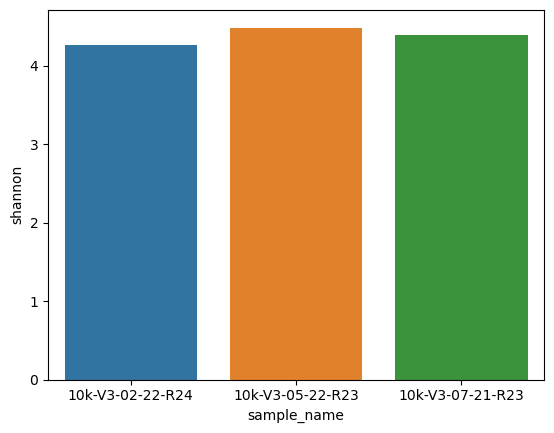

In [22]:
adiv_shannon_df = adiv_shannon.to_frame().reset_index()
adiv_shannon_df.rename(columns = {'index':'sample_name', 0:'shannon'}, inplace=True)
%matplotlib inline
sns.barplot(data=adiv_shannon_df, x='sample_name', y='shannon')

# Step 9.5

## Great! But what about your other metric? Now we will merge results of both metrics in a single table and then plot them toghether.

### Running the cell below will merge shannon metrics with metric of your choice (that you choose previously)

In [23]:
adiv_yourchoice_df = adiv_yourchoice.to_frame().reset_index()

adiv_yourchoice_df.rename(columns= {'index':'sample_name', 0:metric_of_your_choice}, inplace=True)

adiv_shannon_and_yourchoice_df = adiv_shannon_df.merge(adiv_yourchoice_df, on='sample_name')
adiv_shannon_and_yourchoice_df

,sample_name,shannon,heip_e
0,10k-V3-02-22-R24,4.271017,7.546893
1,10k-V3-05-22-R23,4.488641,9.243204
2,10k-V3-07-21-R23,4.389142,7.030479


# Step 9.6

### Now we can plot both results on a single figure

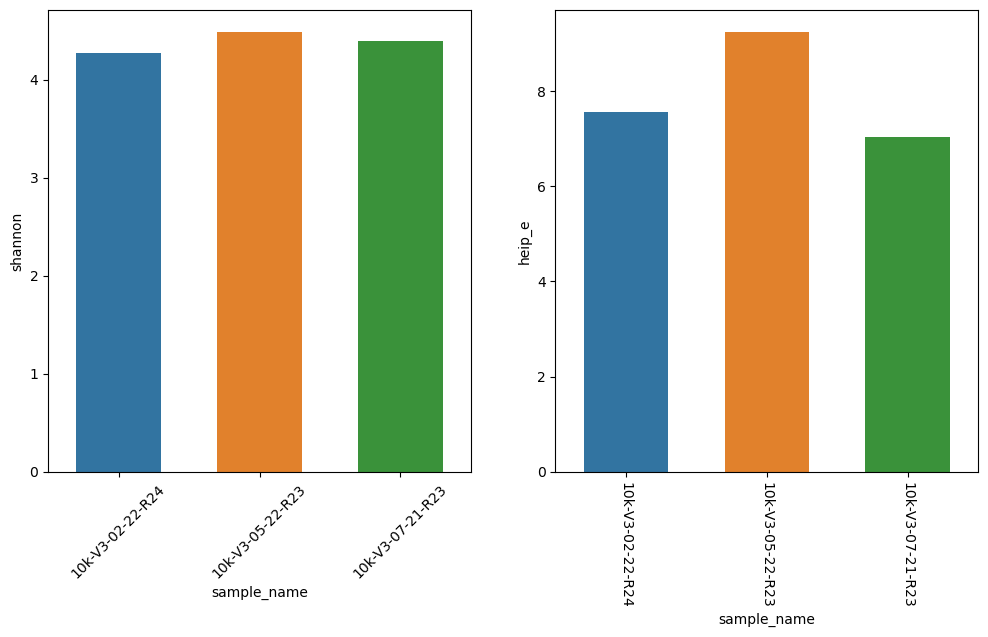

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


sns.barplot(data=adiv_shannon_and_yourchoice_df, x='sample_name', y='shannon', ax=ax1, width=0.6)
sns.barplot(data=adiv_shannon_and_yourchoice_df, x='sample_name', y=metric_of_your_choice, ax=ax2, width=0.6)

ax1.tick_params(axis='x', labelrotation=45)
ax2.tick_params(axis='x', labelrotation=-90)


# Step 10.1

## Heatmap

## Run the Cell below to draw a simple heatmap from our data

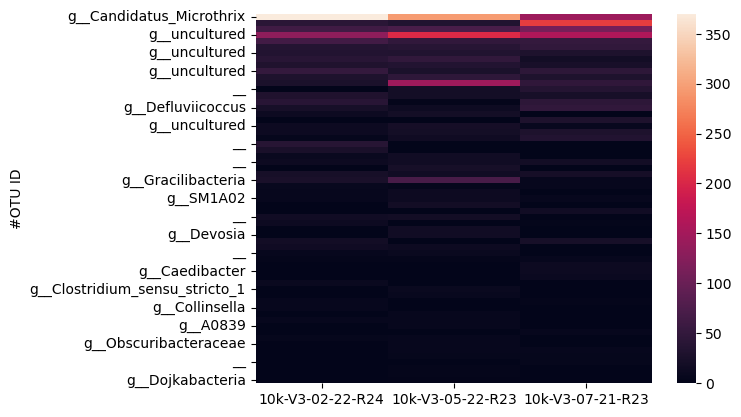

In [25]:
%matplotlib inline
heatmap = sns.heatmap(taxonomic_df)

# Step 10.2

### Its not realy readible, lets select top 20 species:

In [26]:
taxonomic_df_top = taxonomic_df.iloc[:20]
taxonomic_df_top

,10k-V3-02-22-R24,10k-V3-05-22-R23,10k-V3-07-21-R23
#OTU ID,,,
g__Candidatus_Microthrix,370.0,294.0,144.0
__,41.0,32.0,221.0
g__C10-SB1A,63.0,72.0,112.0
g__uncultured,132.0,203.0,160.0
g__Kouleothrix,65.0,48.0,52.0
g__OLB14,36.0,38.0,48.0
g__uncultured,34.0,33.0,29.0
g__LWQ8,40.0,48.0,18.0
g__Novosphingobium,31.0,34.0,24.0


# Step 10.3

#### And replot our heatmap

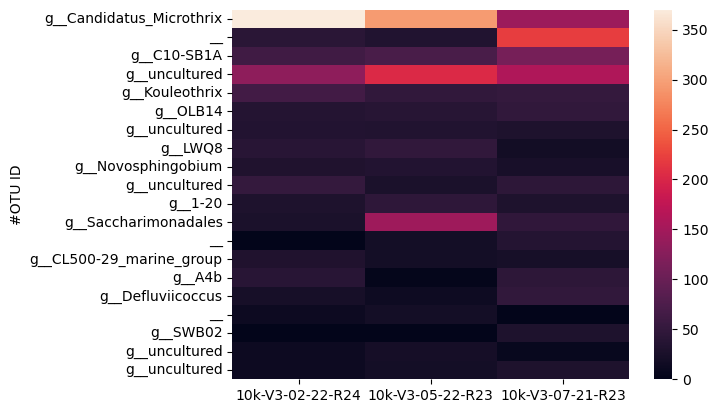

In [27]:
%matplotlib inline
heatmap_top = sns.heatmap(taxonomic_df_top)

# Congratulations! Now we are done!